<a href="https://colab.research.google.com/github/SarahGuo97/Fixed-Income-Final-Project/blob/main/Fall_2020_Final_Exam_Question_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Sarah Guo, yg2060**

1. For ten year US Government bonds futures contract expiring in December, 1st 2020(TYZ0), the following bonds are
deliverable.

In [248]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy.interpolate import interp1d
from datetime import datetime
from dateutil.relativedelta import relativedelta

In [249]:
CMY = pd.read_excel('CMY.xlsx', index_col ='Date')
TYA = pd.read_excel("TYA20201020New.xlsx")

In [250]:
CMY.head()

,1 Mo,2 Mo,3 Mo,6 Mo,1 Yr,2 Yr,3 Yr,5 Yr,7 Yr,10 Yr,20 Yr,30 Yr
Date,,,,,,,,,,,,
2020-01-02,1.53,1.55,1.54,1.57,1.56,1.58,1.59,1.67,1.79,1.88,2.19,2.33
2020-01-03,1.52,1.55,1.52,1.55,1.55,1.53,1.54,1.59,1.71,1.80,2.11,2.26
2020-01-06,1.54,1.54,1.56,1.56,1.54,1.54,1.56,1.61,1.72,1.81,2.13,2.28
2020-01-07,1.52,1.53,1.54,1.56,1.53,1.54,1.55,1.62,1.74,1.83,2.16,2.31
2020-01-08,1.50,1.53,1.54,1.56,1.55,1.58,1.61,1.67,1.78,1.87,2.21,2.35


In [251]:
TYA.head()

,Cash Security,Price,Coupon,Source,Conven Yield,Conver Factor,Gro/Bas (32nds),Implied Repo%,Actual Repo%,Net/Bas (32nds)
0,T 2 ¼ 08/15/27,111-15,2.25,BGN,0.535,0.8006,12.736,0.164,0.12,-0.308
1,T 2 ¼ 11/15/27,111-22+,2.25,BGN,0.559,0.7943,48.205,-4.836,0.12,35.012
2,T 0 ½ 08/31/27,99-21,0.50,BGN,0.551,0.7075,48.054,-7.136,0.12,45.671
3,T 2 ¾ 02/15/28,115-16+,2.75,BGN,0.581,0.8164,72.092,-7.527,0.12,55.993
4,T 0 ½ 06/30/27,99-25,0.50,BGN,0.533,0.7075,52.054,-7.764,0.12,49.724


#### A ) For each of deliverable bonds using Cubic Spline interpolation and CMY find the time series of daily price of the bonds in 2020. 

In [215]:
# read in maturity dates and convert them into string format
maturity_dates = []
for i in range(len(TYA)):
    maturity_date = TYA.iloc[i,0].split()[-1]
    maturity_dates.append(datetime.strptime(maturity_date,'%m/%d/%y').strftime('%Y-%m-%d'))
maturity_dates

['2027-08-15',
 '2027-11-15',
 '2027-08-31',
 '2028-02-15',
 '2027-06-30',
 '2027-07-31',
 '2028-05-15',
 '2027-09-30',
 '2028-08-15',
 '2028-11-15',
 '2029-02-15',
 '2029-05-15',
 '2029-08-15',
 '2029-11-15',
 '2030-02-15',
 '2030-05-15',
 '2030-08-15']

In [216]:
# Form a list of coupon payments dates for all bonds
payments = []
for i in maturity_dates:
  payment = []
  start = '2020-01-02'
  end = i
  temp = end
  while temp > start:
      payment.append(temp)
      new_date = datetime.strptime(temp, '%Y-%m-%d') + relativedelta(months=-6) # each date is 6 month earlier
      temp = new_date.strftime('%Y-%m-%d') # keep format consistent
  payments.append(payment[::-1])
payments

[['2020-02-15',
  '2020-08-15',
  '2021-02-15',
  '2021-08-15',
  '2022-02-15',
  '2022-08-15',
  '2023-02-15',
  '2023-08-15',
  '2024-02-15',
  '2024-08-15',
  '2025-02-15',
  '2025-08-15',
  '2026-02-15',
  '2026-08-15',
  '2027-02-15',
  '2027-08-15'],
 ['2020-05-15',
  '2020-11-15',
  '2021-05-15',
  '2021-11-15',
  '2022-05-15',
  '2022-11-15',
  '2023-05-15',
  '2023-11-15',
  '2024-05-15',
  '2024-11-15',
  '2025-05-15',
  '2025-11-15',
  '2026-05-15',
  '2026-11-15',
  '2027-05-15',
  '2027-11-15'],
 ['2020-02-28',
  '2020-08-28',
  '2021-02-28',
  '2021-08-28',
  '2022-02-28',
  '2022-08-28',
  '2023-02-28',
  '2023-08-28',
  '2024-02-28',
  '2024-08-28',
  '2025-02-28',
  '2025-08-28',
  '2026-02-28',
  '2026-08-28',
  '2027-02-28',
  '2027-08-31'],
 ['2020-02-15',
  '2020-08-15',
  '2021-02-15',
  '2021-08-15',
  '2022-02-15',
  '2022-08-15',
  '2023-02-15',
  '2023-08-15',
  '2024-02-15',
  '2024-08-15',
  '2025-02-15',
  '2025-08-15',
  '2026-02-15',
  '2026-08-15',
  '20

In [217]:
coupon = TYA['Coupon'].tolist()
coupon

[2.25,
 2.25,
 0.5,
 2.75,
 0.5,
 0.375,
 2.875,
 0.375,
 2.875,
 3.125,
 2.625,
 2.375,
 1.625,
 1.75,
 1.5,
 0.625,
 0.625]

In [218]:
time_to_maturity = [1/12,2/12,3/12,6/12,1,2,3,5,7,10,20,30]

def Calculate_bond_price(T, coupon, payments):
  c = coupon/2
  yield_to_maturity = [y/100 for y in CMY.loc[T].tolist()]
  
  # deltaT is the number days from T to payment date
  timeDuration = []
  for p in payments:
    timeDuration.append((datetime.strptime(p, '%Y-%m-%d')-datetime.strptime(T, '%Y-%m-%d')).days)
  timeDuration = list(filter(lambda x: x > 0, timeDuration))
  deltaT = [d/365 for d in timeDuration]

  # Cubic Spline interpolation
  cubic_curve = interp1d(time_to_maturity, yield_to_maturity, kind='cubic', bounds_error=False, fill_value="extrapolate")        
  return sum(c/(1+cubic_curve(deltaT))**deltaT)+(100/(1+cubic_curve(deltaT[-1]))**(deltaT[-1]))

In [219]:
def generate_time_series(i):
  coupon = TYA.loc[i,"Coupon"]
  payment_dates = payments[i]
  timeSeries = []
  for date in CMY.index.strftime('%Y-%m-%d').tolist():
    timeSeries.append(Calculate_bond_price(date,coupon,payment_dates))
  return timeSeries

In [220]:
price = []
for i in range(len(TYA)):
  price.append(generate_time_series(i))

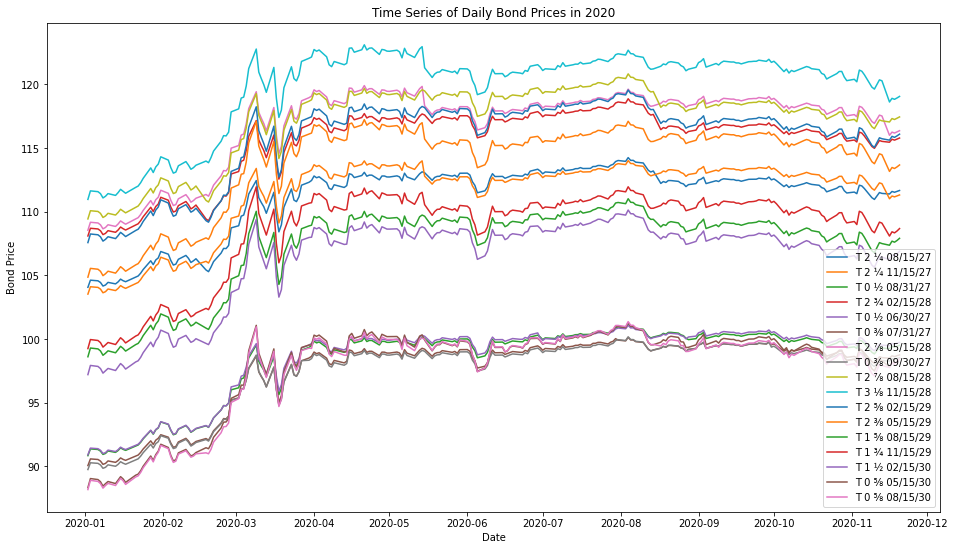

In [229]:
plt.figure(figsize=(16,9))
date = [datetime.strptime(time, "%Y-%m-%d").date() for time in CMY.index.strftime('%Y-%m-%d').tolist()]

for i in range(len(TYA)):
  plt.plot(date,price[i])
  plt.legend(labels=TYA['Cash Security'].tolist(),loc = 'best')
    
plt.title("Time Series of Daily Bond Prices in 2020")
plt.xlabel('Date')
plt.ylabel('Bond Price')
plt.show()

#### B ) Find the daily rate of return of each bond and conversion factor adjusted return (conversion factor adjusted return is simply the daily return multiply by the conversion factor)

In [226]:
# daily return
bond_price = pd.DataFrame(price_list).transpose()
bond_price.columns = TYA['Cash Security']
bond_price.index = date
bond_return = bond_price.pct_change()
bond_return.head()

Cash Security,T 2 ¼ 08/15/27,T 2 ¼ 11/15/27,T 0 ½ 08/31/27,T 2 ¾ 02/15/28,T 0 ½ 06/30/27,T 0 ⅜ 07/31/27,T 2 ⅞ 05/15/28,T 0 ⅜ 09/30/27,T 2 ⅞ 08/15/28,T 3 ⅛ 11/15/28,T 2 ⅝ 02/15/29,T 2 ⅜ 05/15/29,T 1 ⅝ 08/15/29,T 1 ¾ 11/15/29,T 1 ½ 02/15/30,T 0 ⅝ 05/15/30,T 0 ⅝ 08/15/30
2020-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-03,0.005398,0.005568,0.005819,0.005586,0.005728,0.005798,0.005751,0.005906,0.005877,0.006035,0.006286,0.006569,0.006953,0.007148,0.007411,0.007999,0.008209
2020-01-06,-0.000469,-0.000476,-0.000478,-0.000477,-0.000483,-0.000480,-0.000499,-0.000479,-0.000516,-0.000550,-0.000583,-0.000631,-0.000685,-0.000736,-0.000789,-0.000877,-0.000932
2020-01-07,-0.001254,-0.001302,-0.001402,-0.001301,-0.001373,-0.001397,-0.001338,-0.001430,-0.001368,-0.001397,-0.001464,-0.001531,-0.001634,-0.001671,-0.001735,-0.001894,-0.001944
2020-01-08,-0.002681,-0.002768,-0.002843,-0.002789,-0.002795,-0.002827,-0.002873,-0.002883,-0.002933,-0.003013,-0.003124,-0.003255,-0.003423,-0.003519,-0.003641,-0.003907,-0.004014


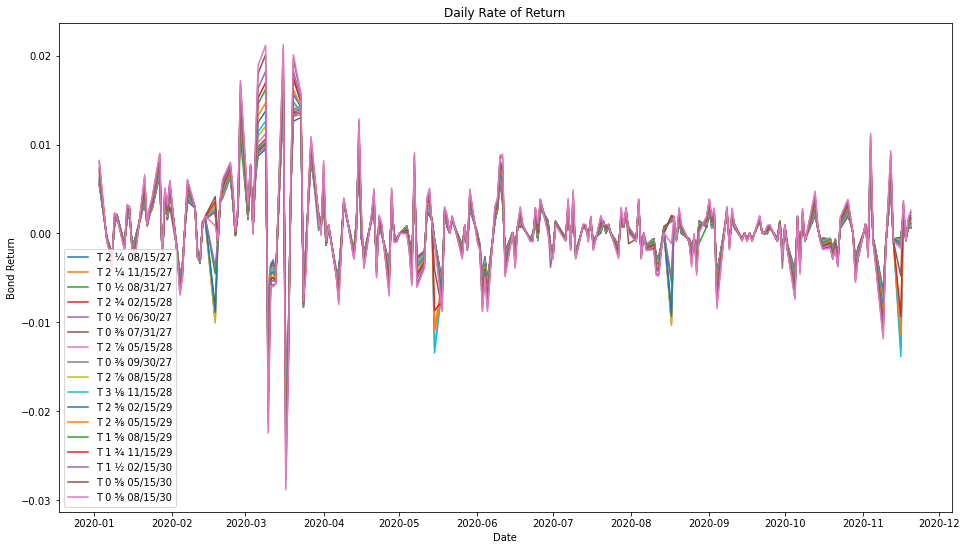

In [234]:
plt.figure(figsize=(16,9))

for i in range(len(TYA)):
  plt.plot(date,bond_return.iloc[:,i])
  plt.legend(labels=TYA['Cash Security'].tolist(),loc = 'best')
    
plt.title("Daily Rate of Return")
plt.xlabel('Date')
plt.ylabel('Bond Return')
plt.show()

In [237]:
# conversion factor adjusted return
adj_bond_return = bond_return.copy()
convF = TYA['Conver Factor'].tolist()
for i in range(len(convF)):
  adj_bond_return.iloc[:,i] *= convF[i]
adj_bond_return.head()

Cash Security,T 2 ¼ 08/15/27,T 2 ¼ 11/15/27,T 0 ½ 08/31/27,T 2 ¾ 02/15/28,T 0 ½ 06/30/27,T 0 ⅜ 07/31/27,T 2 ⅞ 05/15/28,T 0 ⅜ 09/30/27,T 2 ⅞ 08/15/28,T 3 ⅛ 11/15/28,T 2 ⅝ 02/15/29,T 2 ⅜ 05/15/29,T 1 ⅝ 08/15/29,T 1 ¾ 11/15/29,T 1 ½ 02/15/30,T 0 ⅝ 05/15/30,T 0 ⅝ 08/15/30
2020-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-03,0.004321,0.004423,0.004117,0.004560,0.004053,0.004064,0.004707,0.004084,0.004781,0.004972,0.004954,0.005037,0.004951,0.005103,0.005117,0.004980,0.005049
2020-01-06,-0.000375,-0.000378,-0.000338,-0.000390,-0.000341,-0.000336,-0.000409,-0.000331,-0.000420,-0.000453,-0.000459,-0.000484,-0.000488,-0.000525,-0.000544,-0.000546,-0.000573
2020-01-07,-0.001004,-0.001035,-0.000992,-0.001062,-0.000971,-0.000979,-0.001095,-0.000989,-0.001113,-0.001151,-0.001154,-0.001174,-0.001163,-0.001193,-0.001198,-0.001179,-0.001195
2020-01-08,-0.002146,-0.002199,-0.002012,-0.002277,-0.001977,-0.001982,-0.002351,-0.001994,-0.002386,-0.002483,-0.002461,-0.002496,-0.002437,-0.002513,-0.002514,-0.002433,-0.002469


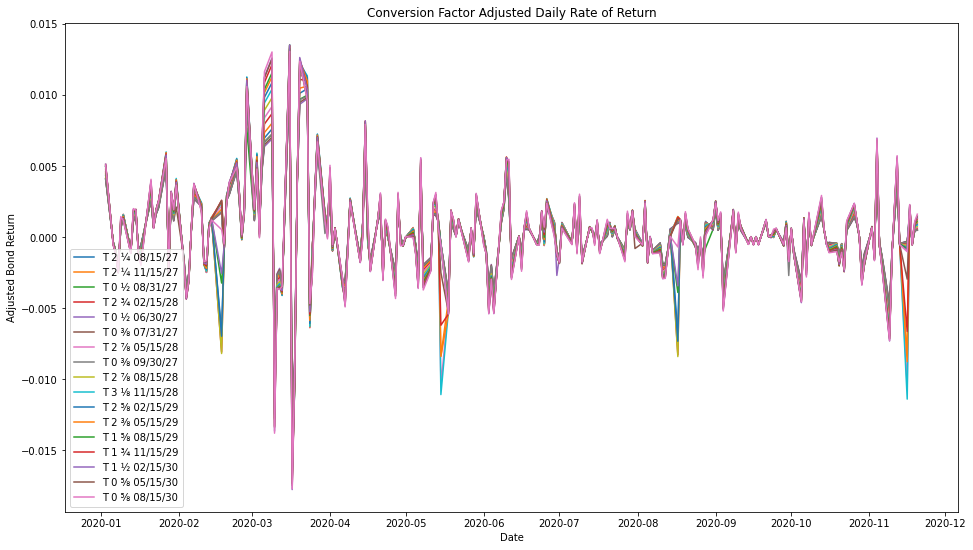

In [240]:
plt.figure(figsize=(16,9))

for i in range(len(TYA)):
  plt.plot(date,adj_bond_return.iloc[:,i])
  plt.legend(labels=TYA['Cash Security'].tolist(),loc = 'best')
    
plt.title("Conversion Factor Adjusted Daily Rate of Return")
plt.xlabel('Date')
plt.ylabel('Adjusted Bond Return')
plt.show()

#### B ) Identify the daily Cheapest to Delivery Bond . 

In [247]:
adj_bond_return.idxmin(axis=1, skipna=True)

2020-01-02               NaN
2020-01-03    T 0 ½ 06/30/27
2020-01-06    T 0 ⅝ 08/15/30
2020-01-07    T 1 ½ 02/15/30
2020-01-08    T 1 ½ 02/15/30
                   ...      
2020-11-16    T 3 ⅛ 11/15/28
2020-11-17    T 0 ½ 06/30/27
2020-11-18    T 1 ½ 02/15/30
2020-11-19    T 0 ½ 06/30/27
2020-11-20    T 0 ½ 06/30/27
Length: 224, dtype: object

#### C ) Compare and comment on the conversion factor adjusted return of the above bonds.

From the two graphs above, we can see that the daily return and the adjusted return has similar patterns: they both reach their peak and fall to the bottom in mid-March. This is mainly due to the volatile trading environment during the COVID-19 pandemic, where interest risk fluctuates between its high and lows.

A large difference in these two returns is the scale. The conversion factor adjusted daily return varies between -0.015 and 0.015, whereas the original bond daily return goes from -0.03 to 0.02. Because conversion factors are mostly smaller than 1, it "smoothed" the bond's daily return when multiplied to it.